<h1 style="text-align: center; font-weight: bold;">Artificial Intelligence Course - Fall 1402</h1>
<h1 style="text-align: center; font-weight: bold;">Soheil Hajian Manesh 810100119</h1>
<h1 style="text-align: center; font-weight: bold;">Computer Assignment 6 - Clustering </h1>

# Problem Description
In this project, we will analyze the news of asriran.ir and trying to predict each data category using Clustering algorithms.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import parsivar as wp
import hazm
import gensim
import numpy as np
import warnings
from gensim.models import Doc2Vec
from bidi.algorithm import get_display
from arabic_reshaper import reshape
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn import metrics
from sklearn.base import BaseEstimator

In [3]:
warnings.filterwarnings("ignore")

In [4]:
TRAIN_DATA_SET = "train.csv"
TEST_DATA_SET = "test.csv"

In [5]:
org_train_dataset = pd.read_csv(TRAIN_DATA_SET)
org_test_dataset = pd.read_csv(TEST_DATA_SET)
display(org_train_dataset)

,label,content
0,فناوری,گزارش های منتشر شده حاکی از آن است که کاربران ...
1,ورزشی,سوپر استار سینما و از قهرمانان سابق ووشو ــ کو...
2,حوادث,مدیرعامل شرکت عمران آب کیش از فوت یک نفر در آت...
3,فناوری,یک نوجوان انگلیسی به اتهام هک حساب‌های کاربری ...
4,سلامت,دانشمندان در جدیدترین مطالعات خود اثرات جدید و...
...,...,...
8995,حوادث,شانزدهم مهر امسال درپی تماس با مرکز فوریت‌های ...
8996,ورزشی,اتحادیه فوتبال ترینیداد و توباگو اعلام کرده تی...
8997,فرهنگی/هنری,اسامی 18 فیلم بخش مسابقه مستند ششمین دوره جشنو...
8998,حوادث,کامیونت حامل بار تخته‌های چوبی عصر دیروز چهارش...


In [6]:
show_persian = lambda x: get_display(reshape(x))

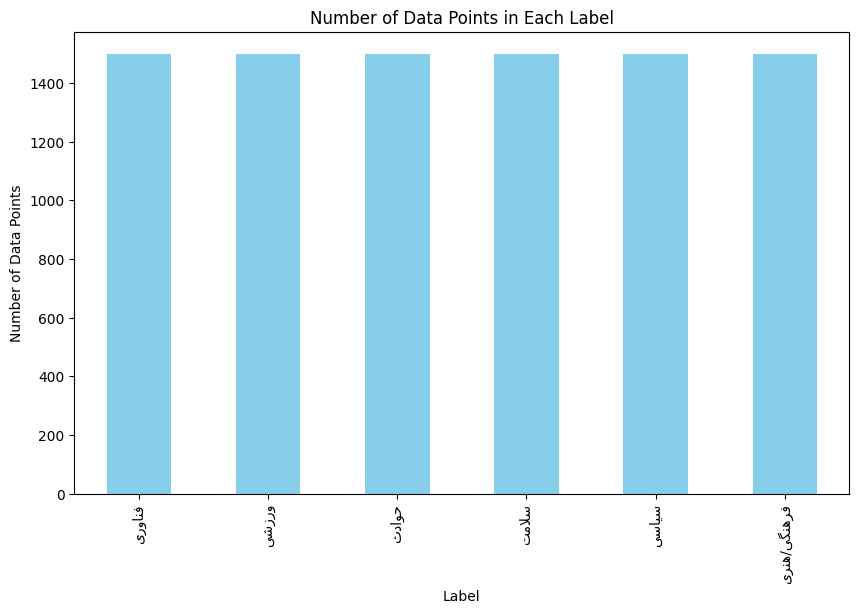

In [7]:
def plot_label_counts(dataset, label_column):
    label_counts = dataset[label_column].value_counts()
    label_counts.index = label_counts.index.map(show_persian)
    plt.figure(figsize=(10, 6))
    label_counts.plot(kind="bar", color="skyblue")
    plt.xlabel("Label")
    plt.ylabel("Number of Data Points")
    plt.title("Number of Data Points in Each Label")
    plt.show()
plot_label_counts(org_train_dataset, "label")

### Question 1 : If the data were unbalanced, what problems would occur in the clustering process? What solution do you offer to solve this problem?

When dataset is unbalanced, it means that some clusters have a significantly higher number of data points compared to others. In the context of clustering, this imbalance can lead to several problems:

1. **Bias toward Larger Clusters**: Most clustering algorithms, such as k-means, tend to be biased toward larger clusters. This can result in smaller but potentially interesting clusters being ignored or merged into larger ones, thus leading to a loss of granularity in the analysis.

2. **Poor Cluster Definition**: Larger clusters can dominate the definition of cluster centers, which can skew the results and does not accurately reflect the characteristics of the smaller clusters.

3. **Decreased Cluster Quality**: The quality of the cluster, in terms of intra-cluster homogeneity and inter-cluster separation, can be significantly decreased because the larger clusters may pull the cluster centroids toward them, increasing the heterogeneity of smaller clusters.

To address these issues, you can consider the following solutions:

1. **Resampling the Data**: You can either downsample the majority class (the larger clusters) or upsample the minority class (the smaller clusters) to ensure that the clustering algorithm does not bias toward the larger ones.

2. **Using Density-Based Clustering Algorithms**: Algorithms like DBSCAN (Density-Based Spatial Clustering of Applications with Noise) or OPTICS (Ordering Points To Identify the Clustering Structure) do not require the number of clusters to be specified a priori and can find clusters of varying sizes and densities, which may provide better results for unbalanced datasets.

3. **Anomaly Detection**: Treat the smaller clusters as anomalies or outliers first. Detect these using anomaly detection techniques and then apply clustering to the balanced dataset.

4. **Cluster Algorithms with Weights**: Some algorithms allow assigning weights to data points, giving you the ability to manually balance the influence of data points on the clustering process.

5. **Pre-processing Techniques**: Use feature transformation or sampling techniques that help to reduce the imbalance before clustering, like SMOTE (Synthetic Minority Over-sampling Technique) for sampling, or PCA (Principal Component Analysis) for feature reduction which may lead to a balanced representation of clusters.

6. **Customized Clustering Algorithms**: Modify existing algorithms or develop new ones that are robust to such imbalances. This could involve incorporating algorithms that minimize a different objective function that is less sensitive to the number of points per cluster.

7. **Post-processing of Clusters**: After clustering on the original unbalanced dataset, refine the clusters by splitting the larger clusters and/or merging smaller ones based on additional criteria such as density or distance metrics.

Analyzing the specific characteristics of an unbalanced dataset and choosing the right combination of techniques is essential for effective clustering in such scenarios.

# PreProcessing

I will use the `Hazm` package to normalize the text and I will use different preprocess strategies and see their effects on accuracy and performance.

### Question 2 : Stemming & Lemmatization
- **Stemming**:    
> It is the process of reducing infected words to their stem. For instance, stemming replace words`history` and `historical` with `histori`.     
> In the words it is process of removing the last few characters of a given word, to obtain a shorter form, even if that form doesn’t have any meaning.
- **Lemmatization**: 
> The purpose of lemmatization is same as that of stemming but overcomes the drawbacks of stemming. In stemming, for some words, it may not give may not give meaningful representation such as `Histori`. Here, lemmatization comes into picture as it gives meaningful word.

#### Stemming vs Lemmatization:
- Definition:     
     - `Stemming` is a process that stems or removes last few characters from a word, often leading to incorrect meanings and spelling.
     - `Lemmatization` considers the context and converts the word to its meaningful base form, which is called Lemma.
- Example:
     - `Stemming` the word `Caring` would return `Car`.
     - `Lemmatizing` the word `Caring` would return `Care`.
- Consideration:
     - `Stemming` is used in case of large dataset where performance is an issue.
     - `Lemmatization` is computationally expensive since it involves look-up tables and what not.

In [8]:
def normalize(df: pd.DataFrame):
    normalizer = hazm.Normalizer()
    df["content"] = df["content"].apply(normalizer.normalize)


def remove_stop_words(df: pd.DataFrame):
    stop_words = set(hazm.stopwords_list())
    df["content"] = df["content"].apply(
        lambda x: " ".join([word for word in x.split() if word not in stop_words])
    )


def remove_punctuations(df: pd.DataFrame):
    punctuations_set = set(["،",":",".","؛",")","(",'"',"»","«","{","}","[","]","!","؟","?",";",",",])
    df["content"] = df["content"].apply(
        lambda x: " ".join([word for word in x.split() if word not in punctuations_set])
    )


def stemming(df: pd.DataFrame):
    stemmer = hazm.Stemmer()
    df["content"] = df["content"].apply(lambda x: ' '.join([stemmer.stem(token) for token in hazm.word_tokenize(x)]))


def lemmatization(df: pd.DataFrame):
    lemmatizer = hazm.Lemmatizer()
    df["content"] = df["content"].apply(lambda x: ' '.join([lemmatizer.lemmatize(token) for token in hazm.word_tokenize(x)]))



In [9]:
def preprocess_dataset(df: pd.DataFrame):
    normalize(df)
    remove_stop_words(df)
    remove_punctuations(df)
    lemmatization(df)
    remove_punctuations(df)
    # remove_stop_words(df)


In [10]:
train_dataset = org_train_dataset.copy()
test_dataset = org_test_dataset.copy()

preprocess_dataset(train_dataset)
preprocess_dataset(test_dataset)

In [11]:
print(org_train_dataset['content'][0])
print(train_dataset['content'][0])

گزارش های منتشر شده حاکی از آن است که کاربران تلگرام در مناطقی از جهان همچون اروپا و خاورمیانه با مشکل مواجه شده اند. به گزارش ایسنا، به نقل از تلگرام، دقایقی پیش پیام رسان تلگرام در صفحه توییتر خود اعلام کرد که دسترسی کاربران این اپلیکیشن در اروپا و خاورمیانه با مشکل مواجه شده است. طبق این پیام، به نظر می رسد که منشا این اختلالات از ظهر امروز، پنج شنبه، خارجی و از سوی خود این پیام رسان بوده است و ارتباطی با داخل کشور ندارد. این پیام رسان در این خصوص عنوان کرده است که متخصصان تلگرام از زمانی که متوجه چنین اختلالی شده اند، در حال بررسی و برطرف کردن مشکل مربوطه بوده و امید است به زودی این اختلال رفع شود و کاربران به حساب های کاربری خود در تلگرام دسترسی یابند.
گزارش منتشر حاکی کاربر تلگرام مناطقی جهان اروپا خاورمیانه مشکل شد#شو گزارش ایسنا نقل تلگرام دقایق پیام‌رسان تلگرام صفحه توییتر اعلام دسترسی کاربر اپلیکیشن اروپا خاورمیانه مشکل است پیام منشا اختلالات ظهر امروز پنج‌شنبه خارجی پیام‌رسان ارتباطی داخل کشور داشت#دار پیام‌رسان عنوان متخصص تلگرام زمانی متوجه اختلال شد#شو بررسی برطرف مشکل مر

In [12]:
dataset = pd.concat([train_dataset, test_dataset], axis=0)

# Clustering

In [13]:
def tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(words=hazm.word_tokenize(list_of_words), tags=[str(i)])

In [14]:
data_for_training = list(tagged_document(train_dataset["content"]))
print(data_for_training[:1])

[TaggedDocument(words=['گزارش', 'منتشر', 'حاکی', 'کاربر', 'تلگرام', 'مناطقی', 'جهان', 'اروپا', 'خاورمیانه', 'مشکل', 'شد#شو', 'گزارش', 'ایسنا', 'نقل', 'تلگرام', 'دقایق', 'پیام\u200cرسان', 'تلگرام', 'صفحه', 'توییتر', 'اعلام', 'دسترسی', 'کاربر', 'اپلیکیشن', 'اروپا', 'خاورمیانه', 'مشکل', 'است', 'پیام', 'منشا', 'اختلالات', 'ظهر', 'امروز', 'پنج\u200cشنبه', 'خارجی', 'پیام\u200cرسان', 'ارتباطی', 'داخل', 'کشور', 'داشت#دار', 'پیام\u200cرسان', 'عنوان', 'متخصص', 'تلگرام', 'زمانی', 'متوجه', 'اختلال', 'شد#شو', 'بررسی', 'برطرف', 'مشکل', 'مربوطه', 'امید', 'زودی', 'اختلال', 'رفع', 'کاربر', 'حساب', 'کاربری', 'تلگرام', 'دسترسی', 'یابید#یاب'], tags=['0'])]


In [15]:
model = Doc2Vec(vector_size=5, window=2, min_count=1, epochs=30)
model.build_vocab(data_for_training)
model.train(data_for_training, total_examples=model.corpus_count, epochs=model.epochs)

In [16]:
feature_vectors = [model.infer_vector(hazm.word_tokenize(words)) for words in dataset["content"]]

## KMN Algorithm

In [17]:
kmn = KMeans(n_clusters=6, n_init=10)
kmn.fit(feature_vectors)
kmn_labels = kmn.predict(feature_vectors)
kmn_center = kmn.cluster_centers_

## DBSCAN Algorithm

In [82]:
def custom_scoring(estimator, X, true_labels):
    labels = estimator.fit_predict(X)
    silhouette = silhouette_score(X, labels)
    homogeneity = homogeneity_score(true_labels, labels)
    score = (homogeneity * silhouette) / (homogeneity + silhouette)
    return score


def apply_grid_search(vectors):
    param_grid = {
        # "eps": [0.1,0.5, 0.8, 1.5, 1.7, 2],
        # "min_samples": range(3, 15),
        "eps": [1.5],
        "min_samples": [8]
    }

    dbscan = DBSCAN()

    dbscanGridSearch = GridSearchCV(dbscan, param_grid, cv=5, scoring=custom_scoring)

    dbscanGridSearch.fit(vectors)

    best_params = dbscanGridSearch.best_params_

    print("Best Parameters:", best_params)

    return best_params["eps"], best_params["min_samples"]


def apply_dbscan(vectors, true_labels):
    eps_train, min_samples_train = apply_grid_search(vectors)

    dbscan = DBSCAN(eps=eps_train, min_samples=min_samples_train)

    dbscan.fit(vectors)
    return dbscan.labels_


dbscan_labels = apply_dbscan(feature_vectors, dataset["label"].tolist())

Best Parameters: {'eps': 1.5, 'min_samples': 8}


### Question 3 : The reason for using the features vector and its features
In `Natural Language Processing NLP`, we use feature vectors because machine learning algorithms cannot work with raw text directly. The algorithms require numerical input to perform any sort of predictive task.       
Also text data can be extremely high dimensional if we consider each unique word as a different dimension. Feature vectors help in reducing the dimensionality of this data.

### Question 4 : How **word2vec** and **doc2vec** work? How convert text to features vector?
`Word2Vec` and `Doc2Vec` are popular techniques for converting text data into distributed representations, often called word vectors or embeddings. These methods are part of the broader field of natural language processing (NLP) and are commonly used in various tasks, such as text classification, sentiment analysis, and information retrieval.      
**Word2Vec:**
1. Skip-gram and Continuous Bag of Words (CBOW):

    - Skip-gram: Predicts the context words given a target word.
    - CBOW: Predicts the target word given its context.
2. Training Process:

    - Objective: Maximize the likelihood of the context words given the target word (or vice versa).
    - Architecture: Neural network with an embedding layer.
3. Result:

    - Each word is represented as a dense vector in a high-dimensional space.
    - Similar words have similar vectors, capturing semantic relationships.

**Doc2Vec:**
1. Paragraph Vector (PV-DM) and Paragraph Vector Distributed Memory (PV-DBOW):

    - PV-DM: Predicts the next word in a context given a paragraph.
    - PV-DBOW: Predicts words randomly sampled from a paragraph.
2. Training Process:

    - Objective: Maximize the likelihood of words given the paragraph vector.
    - Architecture: Neural network with paragraph vectors and word vectors.
3. Result:

    - Each document (paragraph) is represented as a dense vector in the same space as word vectors.
    - Captures document-level semantics.

**Conversion of Text to Feature Vectors:**
1. Tokenization:
    - Split the text into individual words or tokens.
2. Word Embeddings:
    - For Word2Vec: Retrieve pre-trained word embeddings or train them on your specific dataset.
    - For Doc2Vec: Train paragraph vectors using the Doc2Vec model.
3. Aggregation (for Doc2Vec):
    - Combine individual word vectors to create a single vector representation for the entire document.
    - Common methods include averaging or concatenating word vectors.
4. Vector Normalization (Optional):
    - Normalize the resulting vectors to ensure consistent scales.
5. Feature Vector:
    - The final vector serves as the feature representation of the text.

### Question 5 : **K-means** and **DBSCAN** methods and the advantages and disadvantages of these methods.   

1. **K-means Clustering:**      
       
    - `K-means` is a centroid-based or partition-based clustering algorithm.  This algorithm partitions all the points in the sample space into K groups of similarity. The similarity is usually measured using `Euclidean Distance` .
    - ***Algorithm***:
        - K centroids are randomly placed, one for each cluster.
        - Distance of each point from each centroid is calculated
        - Each data point is assigned to its closest centroid, forming a cluster.
        - The position of K centroids are recalculated.
    
2. **DBScan Clustering:**

    - `DBScan` is a density-based clustering algorithm. The key fact of this algorithm is that the neighbourhood of each point in a cluster which is within a given radius (eps) must have a minimum number of points (min_samples). This algorithm has proved extremely efficient in detecting outliers and handling noise.
    - ***Algorithm***:   
        - The type of each point is determined. Each data point in our dataset may be either of the following :
            - `Core Point`: A data point is a core point if, there are at least M points in its neighborhood ie, within the specified radius (R).
            - `Border Point`: A data point is classified as a BORDER point if:
                - Its neighborhood contains less than M data points, or
                - It is reachable from some core point ie, it is within R-distance from a core point.
            - `Outlier Point`: An outlier is a point that is not a core point, and also, is not close enough to be reachable from a core point.
        - The outlier points are eliminated.
        - Core points that are neighbors are connected and put in the same cluster.
        - The border points are assigned to each cluster.

3. **K-means vs DBScan:**
    - ***Form of clusters:***   
    
        >  K-means: Clusters formed are more or less spherical or convex in shape and must have same feature size.   
        >  DBScan: Clusters formed are arbitrary in shape and may not have same feature size.
    - ***Number of clusters:***
        >  K-means: is sensitive to the number of clusters specified.  
        >  DBScan: Number of clusters need not be specified.
    - ***efficiency in large dataset:***
        >  K-means: is more efficient for large datasets.	   
        >  DBScan: can not efficiently handle high dimensional datasets.
    - ***efficiency in noisy dataset:***
        >  K-means: does not work well with outliers and noisy datasets.	   
        >  DBScan: efficiently handles outliers and noisy datasets
    - ***anomaly detection:***
        >  K-means: In the domain of anomaly detection, this algorithm causes problems as anomalous.	   
        >  DBScan: This algorithm,on the other hand, locates regions of high density that are separated from one another by regions of low density.
    - ***efficiency in sparse dataset:***
        >  K-means: Varying densities of the data points doesn’t affect K-means clustering algorithm.	   
        >  DBScan: DBScan clustering does not work very well for sparse datasets or for data points with varying density.

    

# Dimension Reduction

### Question 7 : What is PCA and how it works?

`Principal Component Analysis (PCA)` is a powerful technique used in data analysis, particularly for reducing the dimensionality of datasets while preserving crucial information. It does this by transforming the original variables into a set of new, uncorrelated variables called principal components. Here’s a breakdown of PCA’s key aspects:

* **Dimensionality Reduction:** PCA helps manage high-dimensional datasets by extracting essential information and discarding less relevant features, simplifying analysis.   
   
* **Data Exploration and Visualization:** It plays a significant role in data exploration and visualization, aiding in uncovering hidden patterns and insights.   
   
* **Linear Transformation:** PCA performs a linear transformation of data, seeking directions of maximum variance.   
    
* **Feature Selection:** Principal components are ranked by the variance they explain, allowing for effective feature selection.    
    
* **Data Compression:** PCA can compress data while preserving most of the original information.    
       
* **Clustering and Classification:** It finds applications in clustering and classification tasks by reducing noise and highlighting underlying structure.       

* **Advantages:** PCA offers linearity, computational efficiency, and scalability for large datasets.    
    
* **Limitations:** It assumes data normality and linearity and may lead to information loss.    
   
* **Matrix Requirements:** PCA works with symmetric correlation or covariance matrices and requires numeric, standardized data.    
   
* **Eigenvalues and Eigenvectors:**  Eigenvalues represent variance magnitude, and eigenvectors indicate variance direction.   

* **Number of Components:** The number of principal components chosen determines the number of eigenvectors computed.

#### How Principal Component Analysis (PCA) Work ?

1. Standardize the Data:

      If the features of your dataset are on different scales, it’s essential to standardize them (subtract the mean and divide by the standard deviation).

2. Compute the Covariance Matrix:

      Calculate the covariance matrix for the standardized dataset.

3. Compute Eigenvectors and Eigenvalues:

      Find the eigenvectors and eigenvalues of the covariance matrix. The eigenvectors represent the directions of maximum variance, and the corresponding eigenvalues indicate the magnitude of variance along those directions.

4. Sort Eigenvectors by Eigenvalues:

      Sort the eigenvectors based on their corresponding eigenvalues in descending order.

5. Choose Principal Components:

      Select the top k eigenvectors (principal components) where k is the desired dimensionality of the reduced dataset.

6. Transform the Data:

      Multiply the original standardized data by the selected principal components to obtain the new, lower-dimensional representation of the data.

In [19]:
pca = PCA(n_components=2)
pca_vectors = pca.fit_transform(feature_vectors)

In [20]:
pca_vectors

array([[ 0.56869197,  1.64715165],
       [-3.19493399,  2.12496651],
       [-0.42792524, -0.82363699],
       ...,
       [-0.32898933, -0.47329422],
       [ 4.91245788,  8.09989257],
       [ 6.19932587, -0.48647591]])

In [21]:
def plot_pca(vectors, labels, title):
    plt.scatter(vectors[:, 0], vectors[:, 1], c=labels)
    plt.title(title)



def plot_comparison(vectors ,labels_first, title_first ,labels_second, title_second):

    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)

    plot_pca(vectors ,labels_first, title_first)


    plt.subplot(1, 2, 2)

    plot_pca(vectors ,labels_second, title_second)


    plt.tight_layout()

    plt.show()

## PCA for Kmeans

In [22]:
kmn.fit(pca_vectors)
pca_kmn_labels = kmn.predict(pca_vectors)

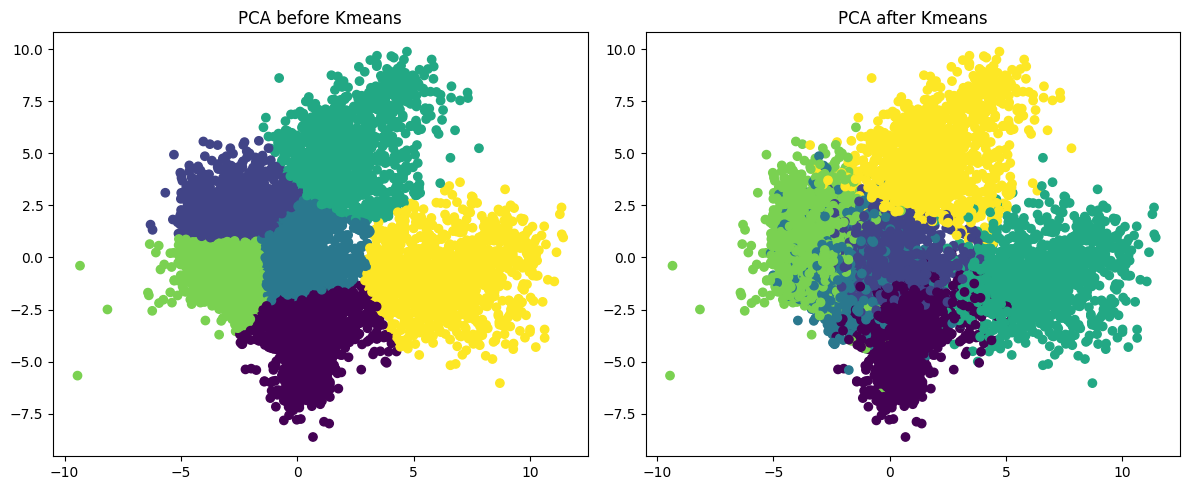

In [23]:
plot_comparison(pca_vectors, pca_kmn_labels, "PCA before Kmeans",kmn_labels,"PCA after Kmeans")

## PCA for DBSCAN

In [83]:
pca_dbscan_labels = apply_dbscan(pca_vectors,dataset["label"].tolist())

Best Parameters: {'eps': 1.5, 'min_samples': 8}


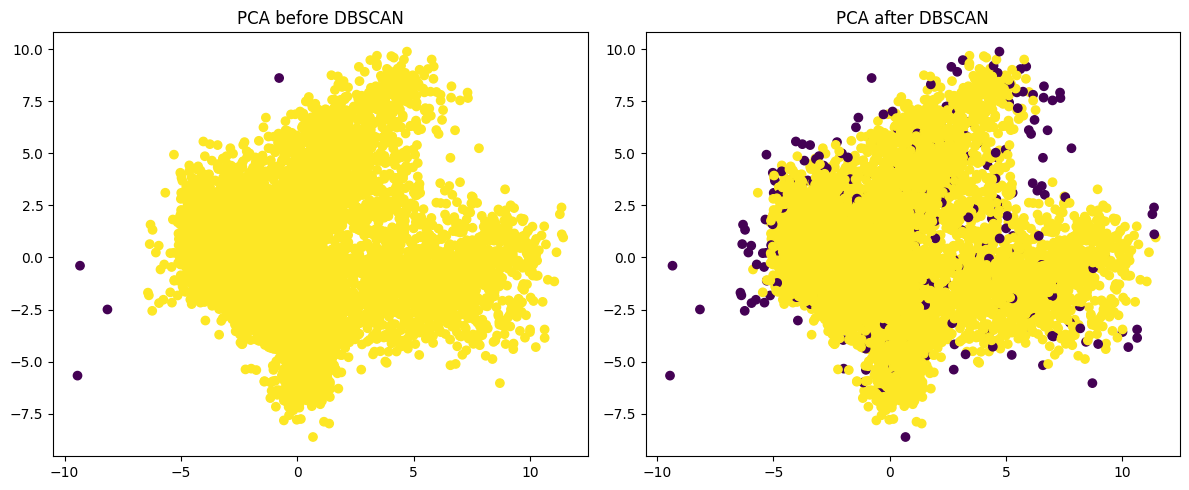

In [84]:
plot_comparison(pca_vectors, pca_dbscan_labels, "PCA before DBSCAN", dbscan_labels, "PCA after DBSCAN")

### Analyse
As you can see in pictures if we applying `PCA before clustering` clustering performance is improved because of emphasizing relevant patterns in the data.is generally recommended when the dataset has a large number of features, and you want to focus on the most informative dimensions. This can lead to more effective clustering.But applying `PCA after clustering` can be useful to explore the structure of the clustered data in a lower-dimensional space. However, this is primarily for interpretability and visualization rather than influencing the clustering process itself.

### Question 8 : Silhouette & Homogeneity
#### Silhouette Score:
If the ground truth labels are not known, evaluation must be performed using the model itself. The `Silhouette Coefficient` is an example of such an evaluation.The `silhouette score` is a measure of how well-separated clusters are. It ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.    
1. **Calculate the average silhouette score for each sample:**   
        
      For each sample, calculate the silhouette score using the following formula:   
 $$s_i = \frac{b_i-a_i}{max(a_i,b_i)}$$  
      where:
* a(i) is the average distance from the i-th sample to the other samples in the same cluster.

* b(i) is the average distance from the i-th sample to the samples in the nearest cluster that the i-th sample is not a part of.
2. **Calculate the average silhouette score across all samples:**

      The overall silhouette score is the average of the silhouette score for each sample.
$$Silhouette\ Score = \frac{\sum_{i=1}^{N} s_i}{N}$$  
      where: 
* N is the number of samples.

#### Homogeneity Score:
Given the knowledge of the ground truth class assignments of the samples, it is possible to define some intuitive metrics using conditional entropy analysis.`Homogeneity` measures whether each cluster contains only members of a single class. It ranges from 0 to 1, where 1 indicates perfect homogeneity.
1. **Calculate the homogeneity of each cluster:**
$$h(C) = 1-\frac{H(C)}{H(T)}$$   
      where:
* C is a cluster.   

* H(C) is the entropy of the cluster.
    
* H(T) is the entropy of the entire dataset.

2. **Calculate the overall homogeneity score:**

      The overall homogeneity score is the weighted average of the homogeneity of each cluster, with the weights being the relative size of the clusters
$$Homogeneity\ Score = \frac{\sum_{C} \frac{|C|*h(C)}{N}}{N}$$  

      where:
* N is the total number of samples.

* ∣C∣ is the number of samples in cluster C.



### Question 9 : calculate **homogeneity** and **silhouette** scores for each clustering method

#### Homogeneity

In [89]:
homogeneity_kmeans = homogeneity_score(dataset["label"], kmn_labels)
homogeneity_dbscan = homogeneity_score(dataset["label"], dbscan_labels)

print(f"K-means Homogeneity Score: {homogeneity_kmeans:.2f}")
print(f"DBScan Homogeneity Score: {homogeneity_dbscan:.3f}")

K-means Homogeneity Score: 0.53
DBScan Homogeneity Score: 0.003


####  Analyze
**K-means** : A homogeneity score of 0.52 is relatively high and suggests that K-means is forming clusters that contain predominantly instances of a single class. This indicates that the clusters created by K-means align well with the class labels in your dataset. The high homogeneity score is indicative of well-defined and internally consistent clusters.       
**DBScan** :  A homogeneity score of 0.003 indicates that DBScan is struggling to create clusters that purely consist of a single class. DBScan is density-based and may not perform well on datasets with complex structures or varying densities. The low homogeneity score suggests that the clusters formed by DBScan do not align well with the class labels in your dataset.
 

#### Silhouette

In [87]:
silhouette_kmeans = silhouette_score(pca_vectors, kmn_labels, metric="euclidean")
silhouette_dbscan = silhouette_score(pca_vectors, dbscan_labels, metric="euclidean")

print(f"K-means Silhouette Score: {silhouette_kmeans:.2f}")
print(f"DBScan Silhouette Score: {silhouette_dbscan:.2f}")

K-means Silhouette Score: 0.24
DBScan Silhouette Score: 0.28


#### Analyse
**K-means**: A Silhouette score of 0.23 suggests that the clusters formed by K-means are somewhat well-defined, but there is still room for improvement. The positive value indicates that, on average, points within the same cluster are closer to each other than to points in neighboring clusters. However, the score is moderate, indicating that there might be some overlap or ambiguity in the cluster boundaries.

**DBScan**: AA Silhouette score of 0.28 is higher than the one for K-means, suggesting that the clusters formed by DBScan are relatively well-separated. The positive value indicates that, on average, points within the same cluster are closer to each other than to points in neighboring clusters. The higher score suggests that DBScan is performing well in terms of creating distinct and well-separated clusters.


### Question 10 : Ways to improve models' performance

### KMeans

1. **Feature Scaling**: KMeans is sensitive to the scale of the data. Features on larger scales can dominate the algorithm's behavior. Standardizing or normalizing your data ensures that each feature contributes equally to the distance computations.

2. **Feature Selection**: Remove irrelevant or redundant features. KMeans can perform poorly if the dataset contains features that are not useful for clustering.

3. **Choosing the Right Number of Clusters (`k`)**: Use methods like the Elbow Method, the Silhouette Coefficient, or the Gap Statistic to determine an appropriate number of clusters.

4. **Initializing Centroids Wisely**: The default method in scikit-learn's KMeans is 'k-means++', which is generally better than random initialization. However, running the algorithm multiple times with different initializations and choosing the best result can also be beneficial.

5. **Handling Non-spherical Data**: KMeans assumes that clusters are spherical and equally sized, which is not always the case. Sometimes transforming the data, e.g., using PCA for dimensionality reduction, can lead to more spherical clusters.

### DBSCAN

1. **Parameter Tuning**:
   - **`eps` and `min_samples`**: These are crucial parameters. Use a k-distance plot to choose an appropriate `eps` value. The `min_samples` can be set based on domain knowledge or experimental tuning.
   - **Distance Metric**: The choice of distance metric (Euclidean, Manhattan, etc.) can significantly affect the results. Choose one that makes sense for your data.

2. **Data Scaling**: Like KMeans, DBSCAN is sensitive to the scale of the data. Normalizing or standardizing your features can lead to better clustering results.

3. **Dealing with High Dimensionality**: In high dimensions, distance metrics become less useful (curse of dimensionality). Dimensionality reduction techniques like PCA or t-SNE might help before applying DBSCAN.

4. **Handling Noise**: DBSCAN can identify outliers as noise. Analyzing these noise points can provide insights and help in adjusting parameters if too many points are classified as noise.

5. **Experimenting with Different Parameters**: There's no one-size-fits-all set of parameters for DBSCAN. Experiment with different values of `eps` and `min_samples`, and assess the clustering results.

### General Tips for Both Algorithms

- **Understanding Your Data**: Know the characteristics of your dataset. Clustering is an exploratory technique, and its success often hinges on how well the data and its features represent the problem you're trying to solve.

- **Use of Domain Knowledge**: Incorporating domain knowledge can guide you in preprocessing, feature engineering, and interpreting the results.

- **Evaluation Metrics**: Use internal evaluation metrics like the Silhouette Coefficient, Calinski-Harabasz Index, or Davies-Bouldin Index to assess the quality of clusters.

- **Visualizing Results**: If feasible, visualize your clustering results using techniques like scatter plots or t-SNE. This can give you insights into the clusters and how well the algorithm is performing.

- **Algorithm Selection**: Sometimes, the chosen algorithm might not be the best fit for the data. Be open to trying different clustering algorithms.

Remember, clustering is as much an art as it is a science, and iterative experimentation is often key to finding the best approach for your specific dataset.
